In [1]:
import torch # pytorch main library 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms # transforms used in the pre-processing of the data
from torchvision.transforms import InterpolationMode
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
from skimage import transform
import torch.optim as optim
import time
import os
import copy
import logging
from sklearn.metrics import confusion_matrix
import yaml
import random
from PIL import Image
import pickle
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

In [2]:
project_directory ='/home/matjaz.cigler1/ENEL645_Project'
model_dir = project_directory + '/Analysis/efficientnet_b5_model_lr_0.001_lr_32'
print(model_dir)
model = torchvision.models.efficientnet_b0(pretrained=True)
#freeze convolutional layers
for param in model.parameters():
    param.requires_grad = True

# Customize the fully connected layer
model.classifier[1] = nn.Linear(in_features = 1280, out_features=7)
model_state = torch.load(model_dir, map_location=torch.device('cpu'))
model.load_state_dict(model_state)
model = model.eval()

/home/matjaz.cigler1/ENEL645_Project/Analysis/efficientnet_b5_model_lr_0.001_lr_32


/home/matjaz.cigler1/software/miniconda3/envs/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/matjaz.cigler1/software/miniconda3/envs/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
class_to_ind = {
        'unfertilized': 0,
        '_PKCa': 1,
        'N_KCa': 2,
        'NP_Ca': 3,
        'NPK_': 4,
        'NPKCa': 5,
        'NPKCa+m+s': 6,
    }

def get_metadata(data_root, croptype, split='train'):
    data_path = os.path.join(data_root, croptype, 'images')
    print("Data root path: ".ljust(40), data_path)
    assert os.path.exists(data_path), "{} does not exist, please check your root_path".format(data_path)
    
    # load split
    split_path = os.path.join(data_root, croptype, split)+'.txt'
    with open(split_path, 'r') as f:
        file_names = f.read().splitlines()
        print("Loading split from: ".ljust(40), split_path)

    # load metadata
    labels = None
    if split != 'test':
        metadata_path = os.path.join(data_root, croptype, 'labels_trainval.yml')
        labels_trainval = yaml.safe_load(open(metadata_path, 'r')) # dict, e.g., {20200422_1.jpg: unfertilized, ...}
        print("Loading labels from: ".ljust(40), metadata_path)



    # date of data aquisition
    dates = [file_name.split('_')[0] for file_name in file_names] # e.g. 20200422_0.jpg -> 20200422

    # if verbose:
    #     print("Num of images: ".ljust(40), len(file_paths))
    #     print("Num of labels: ".ljust(40), sum(Counter(labels).values()), len(Counter(labels).values()),Counter(labels))
    #     print("Num of dates: ".ljust(40), sum(Counter(dates).values()), len(Counter(dates).values()),Counter(dates))

    return file_names, labels_trainval, class_to_ind


In [4]:
class StructuredDataset(Dataset):
    def __init__(self, croptype, split = 'train'):
        self.trainval_img_paths, self.trainval_label_names, self.class_to_ind = get_metadata(project_directory, croptype, split)
        self.trainval_label_idxs = [class_to_ind[i] for i in self.label_names] if self.label_names else None

        # use cache for acceleration
        cache_path = os.path.join(project_directory, 'datasets/cache', croptype, str(im_scale))
        print("Cache path: ".ljust(20), cache_path)
        if not os.path.exists(cache_path):
            os.makedirs(cache_path)

        

In [5]:
def train_val_test_split(data, train_proportion, val_proportion):
    total_size = len(data)
    train_size = int(total_size*train_proportion)
    val_size = int(total_size*val_proportion)
    test_size = int(total_size*(1 - train_proportion - val_proportion))

    random.shuffle(data)
    train_set = data[0:train_size]
    val_set = data[train_size: train_size + val_size]
    test_set = data[val_size: val_size + test_size]

    return train_set, val_set, test_set


    

In [6]:
split = 'trainval'
croptype = 'datasets/WR2021'
im_scale = 896
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
trainval_file_names, trainval_labels_dict, class_to_ind = get_metadata(project_directory, croptype, split)
# train_files, val_files, test_files = train_val_test_split(trainval_file_names, 0.7, 0.15)

labels = [[], [], []]  # List to hold three lists, one for each set
file_paths = [[], [], []]  # List to hold three lists, one for each set
label_idxs = [[], [], []]  # List to hold three lists, one for each set

# Populate lists for train set
for file_name in trainval_file_names:
    labels[0].append(trainval_labels_dict[file_name])
    file_paths[0].append(os.path.join(project_directory, croptype, 'images', file_name))
    label_idxs[0].append(class_to_ind[trainval_labels_dict[file_name]])

# # Populate lists for validation set
# for file_name in val_files:
#     labels[1].append(trainval_labels_dict[file_name])
#     file_paths[1].append(os.path.join(project_directory, file_name))
#     label_idxs[1].append(class_to_ind[trainval_labels_dict[file_name]])

# # Populate lists for test set
# for file_name in test_files:
#     labels[2].append(trainval_labels_dict[file_name])
#     file_paths[2].append(os.path.join(project_directory, file_name))
#     label_idxs[2].append(class_to_ind[trainval_labels_dict[file_name]])

# Convert lists to NumPy arrays
labels = [np.array(sublist) for sublist in labels]
file_paths = [np.array(sublist) for sublist in file_paths]
label_idxs = [np.array(sublist) for sublist in label_idxs]


transform = {
    'TrainVal': transforms.Compose([
    transforms.Resize(456, interpolation=InterpolationMode.BILINEAR),  # Resize images to 256x256 using bilinear interpolation
    # transforms.RandomHorizontalFlip(),
    # transforms.CenterCrop(256),
    # transforms.RandomRotation(180),
    transforms.ToTensor(),  # Convert images to Tensor
    transforms.Normalize(mean, std)  # CHANGE THESE TO THE TRAINF MEAN ANS STD
    ]),

    # 'Validation': transforms.Compose([
    # transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),  # Resize images to 256x256 using bilinear interpolation
    # transforms.CenterCrop(256),
    # transforms.ToTensor(),  # Convert images to Tensor
    # transforms.Normalize(mean, std)  # CHANGE THESE TO THE TRAINF MEAN ANS STD
    # ]),

    # 'Test': transforms.Compose([
    # transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),  # Resize images to 256x256 using bilinear interpolation
    # transforms.CenterCrop(256),
    # transforms.ToTensor(),  # Convert images to Tensor
    # transforms.Normalize(mean, std)  # CHANGE THESE TO THE TRAINF MEAN ANS STD
    # ])
}

# Define your custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Create datasets
datasets = {
    'TrainVal': CustomDataset(file_paths[0], label_idxs[0], transform['TrainVal']),
    # 'Validation': CustomDataset(file_paths[1], label_idxs[1], transform['Validation']),
    # 'Test': CustomDataset(file_paths[2], label_idxs[2], transform['Test'])
}


dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32,
                                             shuffle=(x == 'TrainVal'), num_workers=0)
              for x in ['TrainVal']}
dataset_sizes = {x: len(datasets[x]) for x in ['TrainVal']}


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

Data root path:                          /home/matjaz.cigler1/ENEL645_Project/datasets/WR2021/images
Loading split from:                      /home/matjaz.cigler1/ENEL645_Project/datasets/WR2021/trainval.txt
Loading labels from:                     /home/matjaz.cigler1/ENEL645_Project/datasets/WR2021/labels_trainval.yml


device(type='cpu')

<function matplotlib.pyplot.show(close=None, block=None)>

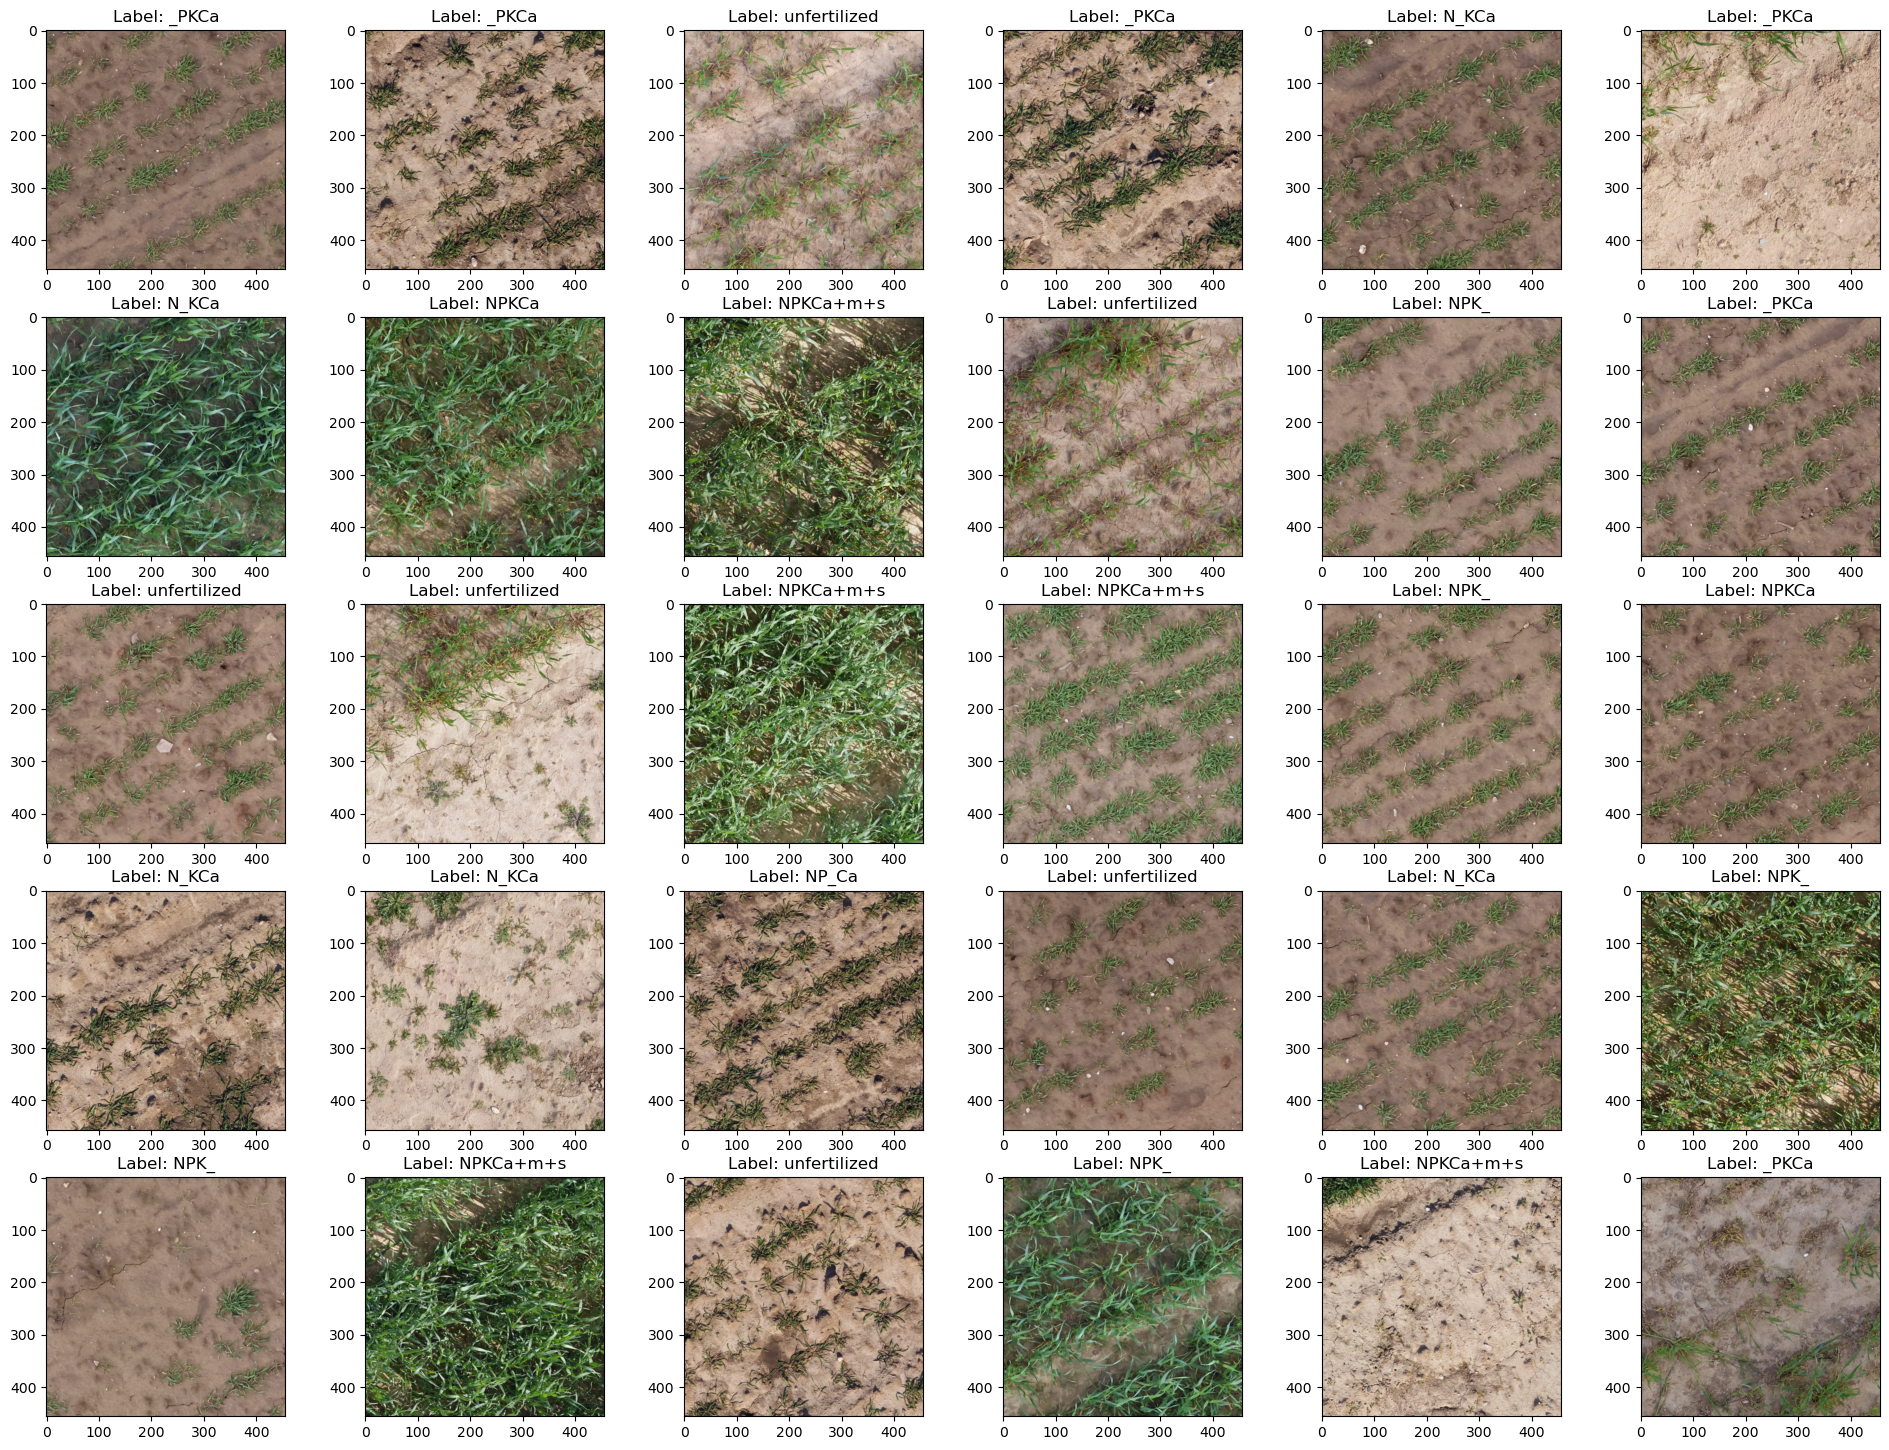

In [7]:
ind_to_class = {v: k for k, v in class_to_ind.items()}
sample_indexes = np.random.choice(len(datasets['TrainVal']),size = 30, replace = False)
plt.figure(figsize= (24, 18))


for(i, j) in enumerate(sample_indexes):
    
    plt.subplot(5,6, i+1)
    image = datasets['TrainVal'][j][0].numpy()
    image = np.transpose(image, (1, 2, 0))
    
    max_val = np.max(image)
    min_val = np.min(image)
    image = (image-min_val) / (max_val-min_val)  # Scale pixel values to [0, 1]
    plt.imshow(image)
    plt.title("Label: %s" %ind_to_class[datasets['TrainVal'][j][1]])
plt.show

## Results

In [8]:
import pandas as pd
from sklearn.metrics import confusion_matrix
test_results_dir = project_directory + '/Analysis/test_results.csv'
print(test_results_dir)


tr_df = pd.read_csv(test_results_dir)

tr_df[tr_df['Model Name'] == 'efficientnet_b0_model']


/home/matjaz.cigler1/ENEL645_Project/Analysis/test_results.csv


Model Name  Batch Size  Learning Rate  Accuracy      Loss  \
60  efficientnet_b0_model           8         0.0500  0.383085  1.483369   
61  efficientnet_b0_model          16         0.0500  0.363184  1.503396   
62  efficientnet_b0_model          32         0.0500  0.402985  1.405816   
63  efficientnet_b0_model          64         0.0500  0.378109  1.530592   
64  efficientnet_b0_model         128         0.0500  0.368159  1.521795   
65  efficientnet_b0_model           8         0.0100  0.373134  1.443692   
66  efficientnet_b0_model          16         0.0100  0.492537  1.199946   
67  efficientnet_b0_model          32         0.0100  0.572139  1.090733   
68  efficientnet_b0_model          64         0.0100  0.562189  1.023011   
69  efficientnet_b0_model         128         0.0100  0.661692  0.936344   
70  efficientnet_b0_model           8         0.0050  0.497512  1.202580   
71  efficientnet_b0_model          16         0.0050  0.537313  1.099254   
72  efficientnet_b0_model          32         0.0050  0.676617  0.843077   
73  efficientnet_b0_model          64         0.0050  0.666667  0.742977   
74  efficientnet_b0_model         128         0.0050  0.766169  0.609602   
75  efficientnet_b0_model           8         0.0010  0.711443  0.815176   
76  efficientnet_b0_model          16         0.0010  0.741293  0.833175   
77  efficientnet_b0_model          32         0.0010  0.736318  0.815105   
78  efficientnet_b0_model          64         0.0010  0.716418  0.744390   
79  efficientnet_b0_model         128         0.0010  0.741293  0.712546   
80  efficientnet_b0_model           8         0.0005  0.746269  0.787089   
81  efficientnet_b0_model          16         0.0005  0.741293  0.727410   
82  efficientnet_b0_model          32         0.0005  0.751244  0.719143   
83  efficientnet_b0_model          64         0.0005  0.601990  0.972085   
84  efficientnet_b0_model         128         0.0005  0.761194  0.694106   
85  efficientnet_b0_model           8         0.0001  0.611940  0.974236   
86  efficientnet_b0_model          16         0.0001  0.701493  0.800311   
87  efficientnet_b0_model          32         0.0001  0.676617  0.785897   
88  efficientnet_b0_model          64         0.0001  0.636816  0.865901   
89  efficientnet_b0_model         128         0.0001  0.631841  1.111168   

                                     Confusion Matrix  
60  [20  1  4  0  2  1  0 19  2  9  2  0  0  0  4 ...  
61  [ 9 11  3  0  0  4  1  8 14  9  0  0  1  0  2 ...  
62  [ 6 13  2  0  3  1  3  8 13  7  0  1  2  1  1 ...  
63  [17  8  1  0  2  0  0 10  9  8  1  2  0  2  0 ...  
64  [15  5  5  0  1  0  2 15  4 10  1  2  0  0  8 ...  
65  [18  6  0  0  0  1  3 13  6 10  0  0  1  2  4 ...  
66  [18  8  0  0  2  0  0  6 16  8  0  1  1  0  0 ...  
67  [19  6  0  0  3  0  0  6 15  7  1  0  2  1  0 ...  
68  [20  4  0  0  2  2  0  7 14  5  1  0  5  0  0 ...  
69  [24  3  0  0  1  0  0  0 23  4  1  0  4  0  0 ...  
70  [15 10  0  0  3  0  0  1 16  4  7  0  4  0  0 ...  
71  [19  5  0  0  3  1  0  4 12 11  0  0  5  0  0 ...  
72  [26  1  0  0  1  0  0  1 17  5  1  0  8  0  0 ...  
73  [28  0  0  0  0  0  0  1 18  2  1  0  9  1  0 ...  
74  [26  0  0  1  1  0  0  0 22  2  1  0  7  0  0 ...  
75  [21  2  0  0  5  0  0  0 16  2  2  1 11  0  0 ...  
76  [26  0  0  0  2  0  0  2 16  6  1  0  7  0  1 ...  
77  [26  0  0  1  1  0  0  0 12  6  1  1 10  2  0 ...  
78  [24  1  0  0  3  0  0  0 21  5  0  0  6  0  0 ...  
79  [26  1  0  0  0  0  1  0 15  3  1  1 12  0  0 ...  
80  [25  1  0  0  2  0  0  1 17  8  0  0  6  0  0 ...  
81  [27  1  0  0  0  0  0  1 17  7  0  0  7  0  0 ...  
82  [27  0  0  0  1  0  0  1 19  4  0  0  8  0  0 ...  
83  [20  1  0  0  4  2  1  1 20  4  2  0  5  0  0 ...  
84  [25  1  0  0  2  0  0  0 17  7  0  0  8  0  0 ...  
85  [21  3  0  0  3  1  0  2 15  2  6  0  7  0  1 ...  
86  [27  0  0  0  1  0  0  1 15  4  2  0  9  1  0 ...  
87  [24  0  0  0  3  1  0  2 12 10  0  0  7  1  0 ...  
88  [24  0  0  0  3  0  1  2 15  8

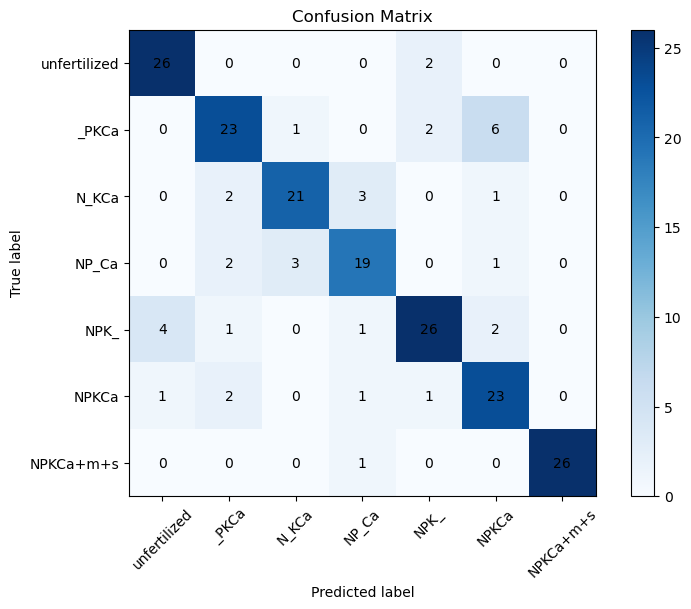

In [10]:

best_model_col = tr_df[tr_df.Accuracy == tr_df.Accuracy.max()]
best_cm_str = best_model_col['Confusion Matrix'].iloc[0]
best_cm_str = best_cm_str.strip('[]')
best_cm = np.array([int(x) for x in best_cm_str.split()]).reshape(7,7)

classes = [
        'unfertilized',
        '_PKCa',
        'N_KCa',
        'NP_Ca',
        'NPK_',
        'NPKCa',
        'NPKCa+m+s',
]
# Calculate class-specific accuracy
class_accuracy = np.diag(best_cm) / np.sum(best_cm, axis=1)

plt.figure(figsize=(8, 6))
plt.imshow(best_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(best_cm))
plt.xticks(tick_marks,classes, rotation=45)
plt.yticks(tick_marks, classes)

# Annotate the heatmap with the counts
for i in range(len(best_cm)):
    for j in range(len(best_cm[i])):
        plt.text(j, i, str(best_cm[i][j]), ha='center', va='center', color='black')

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

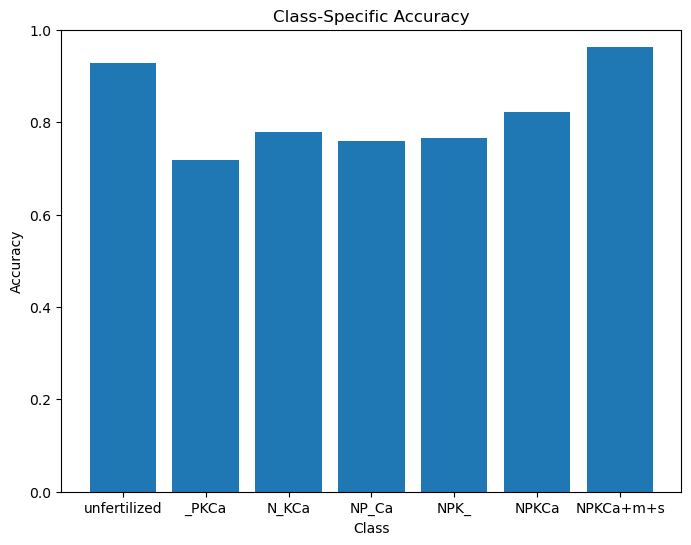

In [ ]:
class_to_ind = {
        'unfertilized': 0,
        '_PKCa': 1,
        'N_KCa': 2,
        'NP_Ca': 3,
        'NPK_': 4,
        'NPKCa': 5,
        'NPKCa+m+s': 6,
    }
labels_map = {v: k for k, v in class_to_ind.items()}


plt.figure(figsize=(8, 6))
plt.bar(classes, class_accuracy)
plt.title('Class-Specific Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Setting y-axis limit from 0 to 1
plt.show()


In [11]:
tr_df.set_index(["Model Name", "Learning Rate", "Batch Size"], inplace=True)
tr_df


Accuracy      Loss  \
Model Name            Learning Rate Batch Size                       
SwinV2Model           0.0500        8           0.606965  2.286532   
                                    16          0.646766  1.476590   
                                    32          0.691542  1.038164   
                                    64          0.676617  0.980820   
                                    128         0.646766  0.981883   
...                                                  ...       ...   
efficientnet_b5_model 0.0100        8           0.313433  1.559878   
                      0.0050        8           0.388060  1.459229   
                      0.0010        8           0.741293  0.611651   
                      0.0005        8           0.726368  0.620554   
                      0.0001        8           0.661692  0.994547   

                                                                                 Confusion Matrix  
Model Name            Learning Rate Batch Size                                                     
SwinV2Model           0.0500        8           [20  2  0  1  3  2  0  2 10  8  2  1  9  0  0 ...  
                                    16          [22  3  0  0  1  2  0  3 11  5  1  0 12  0  1 ...  
                                    32          [23  3  0  0  0  2  0  3 12 10  1  0  6  0  1 ...  
                                    64          [22  4  0  1  0  1  0  3 12  7  2  0  8  0  0 ...  
                                    128         [23  3  1  0  0  1  0  0 13  9  3  0  7  0  0 ...  
...                                                                                           ...  
efficientnet_b5_model 0.0100        8           [20  0  1  0  0  0  3 26  0  1  0  0  2  3 20 ...  
                      0.0050        8           [19  0  1  0  2  1  1 22  4  2  0  0  1  3 12 ...  
                      0.0010        8           [22  0  0  0  2  0  0  3 16  5  6  1  1  0  0 ...  
                      0.0005        8           [16  0  0  1  7  0  0  0 22  4  2  2  2  0  0 ...  
                      0.0001        8           [23  0  0  0  1  0  0  2 21  2  3  0  4  0  0 ...  

[178 rows x 3 columns]

In [12]:

best_accuracy_by_model = tr_df[tr_df.Accuracy == tr_df.groupby('Model Name')['Accuracy'].transform('max')]
best_accuracy_by_model

Accuracy      Loss  \
Model Name            Learning Rate Batch Size                       
SwinV2Model           0.0500        32          0.691542  1.038164   
ResNextModel          0.0100        16          0.557214  1.255158   
                      0.0050        64          0.557214  1.168342   
efficientnet_b0_model 0.0050        128         0.766169  0.609602   
efficientnet_b1_model 0.0050        64          0.815920  0.456214   
efficientnet_b2_model 0.0005        16          0.800995  0.516052   
efficientnet_b3_model 0.0010        16          0.810945  0.487317   
efficientnet_b4_model 0.0050        16          0.810945  0.454029   
efficientnet_b5_model 0.0010        8           0.741293  0.611651   

                                                                                 Confusion Matrix  
Model Name            Learning Rate Batch Size                                                     
SwinV2Model           0.0500        32          [23  3  0  0  0  2  0  3 12 10  1  0  6  0  1 ...  
ResNextModel          0.0100        16          [14  1  1  3  6  0  3  3 11  5  8  2  2  1  1 ...  
                      0.0050        64          [20  2  1  0  3  2  0  6  9  3  3  0 10  1  3 ...  
efficientnet_b0_model 0.0050        128         [26  0  0  1  1  0  0  0 22  2  1  0  7  0  0 ...  
efficientnet_b1_model 0.0050        64          [26  0  0  0  2  0  0  0 23  1  0  2  6  0  0 ...  
efficientnet_b2_model 0.0005        16          [26  1  0  1  0  0  0  1 18  6  0  0  7  0  0 ...  
efficientnet_b3_model 0.0010        16          [23  0  0  1  0  0  0  1 24  2  2  0  3  0  0 ...  
efficientnet_b4_model 0.0050        16          [24  0  0  0  0  0  0  3 25  1  3  0  0  0  0 ...  
efficientnet_b5_model 0.0010        8           [22  0  0  0  2  0  0  3 16  5  6  1  1  0  0 ...

In [13]:
# Reset index to convert grouped DataFrame to a regular DataFrame
best_accuracy_by_model.reset_index(inplace=True)

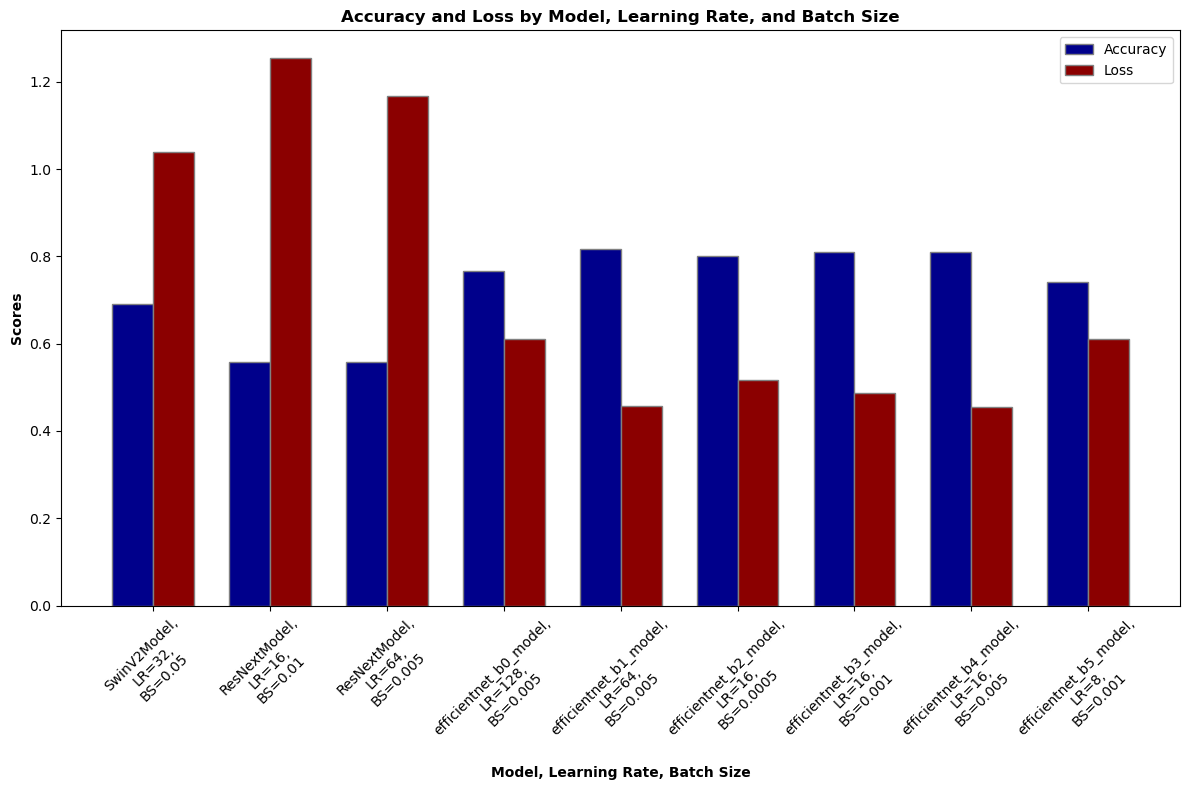

In [14]:

# Set width of bar
bar_width = 0.35

# Set position of bar on X axis
r1 = np.arange(len(best_accuracy_by_model))
r2 = [x + bar_width for x in r1]

# Create bar graph
plt.figure(figsize=(12, 8))
plt.bar(r1, best_accuracy_by_model.Accuracy, color='darkblue', width=bar_width, edgecolor='grey', label='Accuracy')
plt.bar(r2, best_accuracy_by_model.Loss, color='darkred', width=bar_width, edgecolor='grey', label='Loss')

# Add labels and title
plt.xlabel('Model, Learning Rate, Batch Size', fontweight='bold')
plt.ylabel('Scores', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(best_accuracy_by_model))], 
           [f'{model},\nLR={lr},\nBS={bs}' for model, lr, bs in zip(best_accuracy_by_model['Model Name'], best_accuracy_by_model['Batch Size'], best_accuracy_by_model['Learning Rate'])], 
           rotation=45, ha='center')  # Adjust rotation angle and alignment of labels
plt.title('Accuracy and Loss by Model, Learning Rate, and Batch Size', fontweight='bold')

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

3D model with x and y batch and lr and z accuracy


In [15]:

print(f"3D model for {best_model_col['Model Name'].iloc[0]}")
best_model_all_hypers = tr_df.loc[best_model_col['Model Name'].iloc[0]].copy()
best_model_all_hypers.drop(columns=['Confusion Matrix'], inplace=True)


3D model for efficientnet_b1_model


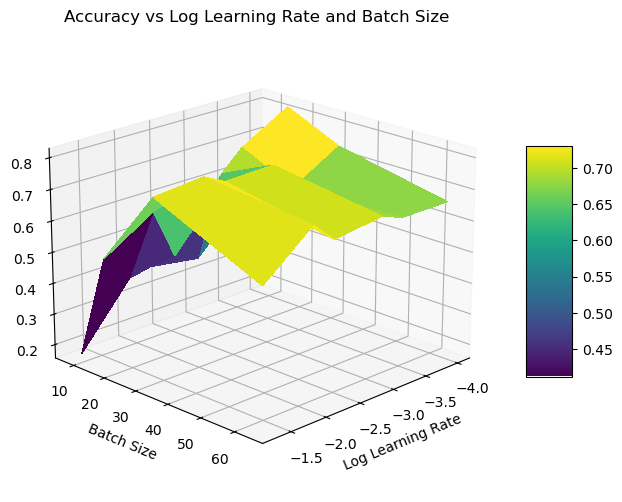

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import cm

# Extracting data
learning_rates = best_model_all_hypers.index.get_level_values('Learning Rate').unique()
batch_sizes = best_model_all_hypers.index.get_level_values('Batch Size').unique()
accuracy = best_model_all_hypers['Accuracy'].values

# Creating meshgrid for 3D plotting with higher resolution
X, Y = np.meshgrid(np.log10(learning_rates), batch_sizes)
Z = accuracy.reshape(len(batch_sizes), len(learning_rates))

# Creating 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting the surface with a finer colormap
surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis, linewidth=0, antialiased=False)

# Fine-tuning the colormap and lighting
ax.set_facecolor('white')
ax.view_init(elev=20, azim=45)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.grid(True)

# Labeling axes
ax.set_xlabel('Log Learning Rate')
ax.set_ylabel('Batch Size')
ax.set_zlabel('Accuracy')

# Title
plt.title('Accuracy vs Log Learning Rate and Batch Size')

# Annotating peaks
max_indices = np.unravel_index(np.argmax(Z, axis=None), Z.shape)

# Show plot
plt.show()

In [17]:
train_results_dir = project_directory + '/Analysis/trainValTest_log.csv'
train_df = pd.read_csv(train_results_dir)


In [18]:
train_df.reset_index(inplace=True)  # Resetting the index to turn the MultiIndex into regular columns
train_df.set_index(['Model Name', 'Phase', 'Learning Rate', 'Batch Size'], inplace=True)
train_df

index  Epoch  \
Model Name            Phase      Learning Rate Batch Size                 
SwinV2Model           Train      0.0500        8               0      1   
                      Validation 0.0500        8               1      1   
                      Train      0.0500        8               2      2   
                      Validation 0.0500        8               3      2   
                      Train      0.0500        8               4      3   
...                                                          ...    ...   
efficientnet_b5_model Validation 0.0001        8            7957     10   
                      Train      0.0001        8            7958     11   
                      Validation 0.0001        8            7959     11   
                      Train      0.0001        8            7960     12   
                      Validation 0.0001        8            7961     12   

                                                               Loss  Accuracy  \
Model Name            Phase      Learning Rate Batch Size                       
SwinV2Model           Train      0.0500        8           9.848471  0.314378   
                      Validation 0.0500        8           9.617866  0.402010   
                      Train      0.0500        8           8.325268  0.395923   
                      Validation 0.0500        8           9.652430  0.487437   
                      Train      0.0500        8           6.968426  0.474249   
...                                                             ...       ...   
efficientnet_b5_model Validation 0.0001        8           0.848199  0.718593   
                      Train      0.0001        8           0.109705  0.976395   
                      Validation 0.0001        8           0.843858  0.713568   
                      Train      0.0001        8           0.097477  0.979614   
                      Validation 0.0001        8           0.847232  0.698492   

                                                           Patience Count  
Model Name            Phase      Learning Rate Batch Size                  
SwinV2Model           Train      0.0500        8                        0  
                      Validation 0.0500        8                        0  
                      Train      0.0500        8                        0  
                      Validation 0.0500        8                        1  
                      Train      0.0500        8                        1  
...                                                                   ...  
efficientnet_b5_model Validation 0.0001        8                        4  
                      Train      0.0001        8                        4  
                      Validation 0.0001        8                        5  
                      Train      0.0001        8                        5  
                      Validation 0.0001        8                        6  

[7962 rows x 5 columns]

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [20]:
best_model_trainval_df = train_df.loc[best_model_col['Model Name'].iloc[0]]


In [21]:
#best model train and val information
best_model_trainval_df.reset_index(inplace= True)
best_model_trainval_df =  best_model_trainval_df[best_model_trainval_df['Batch Size'] == best_model_col['Batch Size'].iloc[0]]
best_model_trainval_df =  best_model_trainval_df[best_model_trainval_df['Learning Rate'] == best_model_col['Learning Rate'].iloc[0]]
best_model_trainval_df.set_index(['Phase'], inplace= True)
##use the following to create the plots
best_model_train_df = best_model_trainval_df.loc['Train']
best_model_Val_df = best_model_trainval_df.loc['Validation']



In [22]:
#best model of each type train and val info
best_model_each_type = best_accuracy_by_model.drop(columns= ['Accuracy', 'Loss', 'Confusion Matrix'])
train_df_copy = train_df.copy()
train_df_copy.reset_index(inplace= True)
best_all_models_trainval_df = pd.DataFrame()
# Iterate over the rows of best_model_each_type
for x in range(len(best_model_each_type)):
    model_name = best_model_each_type['Model Name'].iloc[x]
    batch_size = best_model_each_type['Batch Size'].iloc[x]
    learning_rate = best_model_each_type['Learning Rate'].iloc[x]

    # Create a boolean mask for the current combination of model, batch size, and learning rate
    mask = (train_df_copy['Model Name'] == model_name) & \
           (train_df_copy['Batch Size'] == batch_size) & \
           (train_df_copy['Learning Rate'] == learning_rate)

    # Filter the DataFrame based on the boolean mask and append to best_models_trainval_df
    best_all_models_trainval_df = pd.concat([best_all_models_trainval_df, train_df_copy[mask]])

best_all_models_trainval_df.set_index(['Phase'], inplace= True)
##use the following to create the plots
best_all_models_train_df = best_all_models_trainval_df.loc['Train']
best_all_models_Val_df = best_all_models_trainval_df.loc['Validation']




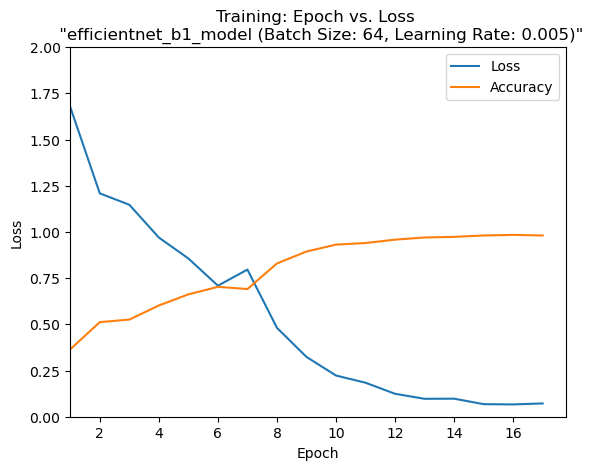

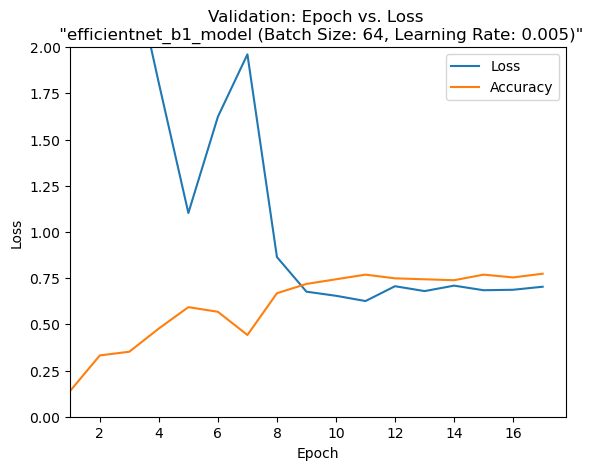

In [23]:

# Extracting information for the legend
for i, df in enumerate([best_model_train_df, best_model_Val_df]):
    batch_size = df['Batch Size'].iloc[0]
    learning_rate = df['Learning Rate'].iloc[0]
    legend_label = f"{best_model_col['Model Name']} (Batch Size: {batch_size}, Learning Rate: {learning_rate})"

    # Plotting epoch vs. loss for the current model
    plt.plot(df['Epoch'], df['Loss'], label="Loss")

    # Extracting information for the legend
    batch_size = df['Batch Size'].iloc[0]
    learning_rate = df['Learning Rate'].iloc[0]
    legend_label = f"{best_model_col['Model Name']} (Batch Size: {batch_size}, Learning Rate: {learning_rate})"

    # Plotting epoch vs. loss for the current model
    plt.plot(df['Epoch'], df['Accuracy'], label="Accuracy")

    # Adding labels and legend
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    if(i == 0):
        phase = 'Training'
    else:
        phase = 'Validation'
    plt.title(f'{phase}: Epoch vs. Loss \n "{best_model_col['Model Name'].iloc[0]} (Batch Size: {batch_size}, Learning Rate: {learning_rate})"')
    plt.legend()
    plt.xlim(left=1)
    plt.ylim(0, 2)

    # Display plot
    plt.show()

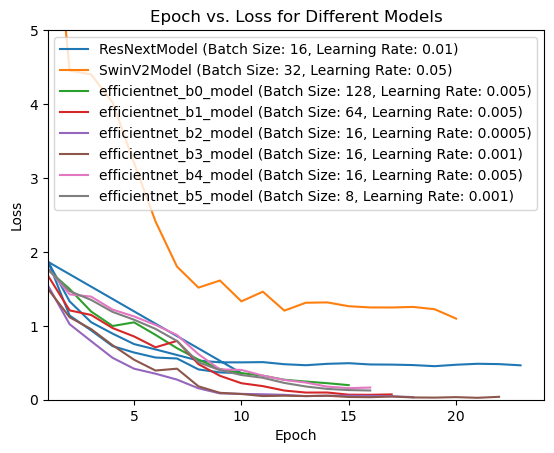

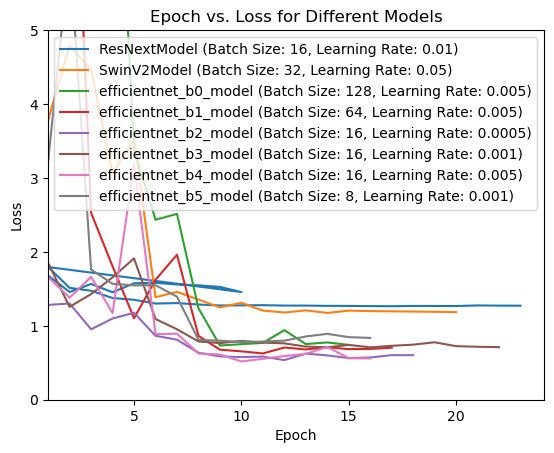

In [24]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing epoch vs. loss data for each model
# Reset index if 'Model Name', 'Batch Size', and 'Learning Rate' are part of the index
for df in [best_all_models_train_df, best_all_models_Val_df]:    
    df.reset_index(inplace=True)

    # Iterate over each unique 'Model Name'
    for name, group in df.groupby('Model Name'):
        # Extracting information for the legend
        batch_size = group['Batch Size'].iloc[0]
        learning_rate = group['Learning Rate'].iloc[0]
        legend_label = f"{name} (Batch Size: {batch_size}, Learning Rate: {learning_rate})"

        # Plotting epoch vs. loss for the current model
        plt.plot(group['Epoch'], group['Loss'], label=legend_label)

    # Adding labels and legend
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Epoch vs. Loss for Different Models')
    plt.legend()
    plt.xlim(left=1)
    plt.ylim(0,5)

    # Display plot
    plt.show()

In [60]:
model.classifier[1]

Linear(in_features=1280, out_features=7, bias=True)

In [ ]:

print(f"3D model for {best_model_col['Model Name'].iloc[0]}")
best_model_all_hypers = tr_df.loc[best_model_col['Model Name'].iloc[0]].copy()
best_model_all_hypers.drop(columns=['Confusion Matrix'], inplace=True)


3D model for efficientnet_b1_model


/tmp/ipykernel_3654892/3175498326.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_tensor = torch.tensor(image_sample).unsqueeze(0)


Linear(in_features=1280, out_features=7, bias=True)
[[[ 0.3651854   0.02269024 -0.11430778 ... -0.78217316  0.4850587
    1.0330508 ]
  [ 0.93030226  0.9131775   0.50218344 ... -0.8335474   0.43368444
    0.74193   ]
  [ 0.5878072   0.74193     0.9131775  ... -0.95342064 -0.14855729
    1.1186745 ]
  ...
  [ 1.1015497   0.63918144  0.57068247 ...  0.810429    0.3651854
    0.7761795 ]
  [ 0.8960528   0.39943492  0.39943492 ...  0.10831413 -0.7136741
   -0.25130582]
  [ 0.7761795   0.27956167  0.03981499 ...  0.21106265 -0.02868402
    0.07406463]]

 [[-0.09243695 -0.42507    -0.512605   ... -1.0378151   0.15266106
    0.71288526]
  [ 0.57282925  0.55532223  0.13515405 ... -1.0028011   0.2226892
    0.4677872 ]
  [ 0.2752102   0.4327732   0.57282925 ... -1.055322   -0.32002798
    0.88795525]
  ...
  [ 0.7303922   0.2577032   0.18767506 ...  0.3452382  -0.09243695
    0.3627452 ]
  [ 0.50280124 -0.00490195 -0.02240895 ... -0.33753496 -1.160364
   -0.687675  ]
  [ 0.3802522  -0.12745096 

<function matplotlib.pyplot.show(close=None, block=None)>

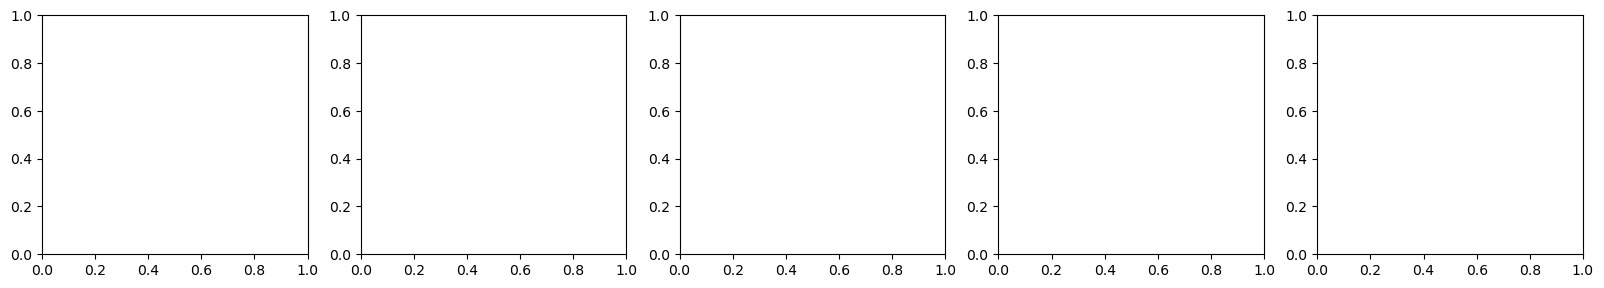

In [69]:

class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()
        
    def __call__(self, model_output):
        return (model_output[self.category, :, : ] * self.mask).sum()



sample_indexes = np.random.choice(len(datasets['TrainVal']),size = 5, replace = False)
plt.figure(figsize= (24, 18))
for(i, j) in enumerate(sample_indexes):
    plt.subplot(5,6, i+1)
    sample = datasets['TrainVal'][j]

    image_sample = sample[0]
    image_sample_permuted = image_sample.permute(1, 2, 0)
    image_sample_np = image_sample_permuted.numpy()
    
    input_tensor = preprocess_image(image_sample_np,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
    image_tensor = torch.tensor(image_sample).unsqueeze(0) 
    image_tensor = image_tensor.to(device)
    output = model(image_tensor)
    print(model.classifier[1])
    target_layers = [model.classifier[1]]
    nutrient_category = datasets['TrainVal'][j][0].numpy()
    normalized_masks = torch.nn.functional.softmax(output, dim=1).cpu()
    nutrient_mask = normalized_masks[0, :].argmax(axis=0).detach().cpu().numpy()
    nutrient_mask_uint8 = 255 * np.uint8(nutrient_mask == nutrient_category)
    nutrient_mask_float = np.float32(nutrient_mask == nutrient_category)

    targets = [SemanticSegmentationTarget(nutrient_category, nutrient_mask_float)]
    print(targets[0].category)
    print("1")
    with GradCAM(model=model,
             target_layers=target_layers,) as cam:
        print("2")
        grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets)[0, :]
        print("2")
        cam_image = show_cam_on_image(image_sample, grayscale_cam, use_rgb=True)
        print("3")
        image1 = np.transpose(cam_image, (1, 2, 0))
    
        max_val = np.max(image1)
        min_val = np.min(image1)
        image1 = (image1-min_val) / (max_val-min_val)  # Scale pixel values to [0, 1]
        plt.imshow(image1)
        plt.title("Label: %s" %ind_to_class[datasets['TrainVal'][j][1]])
plt.show

